In [9]:
#import libraries
import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import glob
from skimage import io, transform
from matplotlib import pyplot as plt
import os
import re
import shutil


In [11]:
#data preperation

root_dir = '/content/drive/MyDrive/hand_drawn/'
image_formats = ['.jpg','.jpeg','.JPG','.png','.JPEG','.PNG']

for file in os.listdir(root_dir):
  filename = os.fsdecode(file)
  for ext in image_formats:
    if filename.endswith(ext):
      circuit = int(re.search(r'\d+', filename).group())
      if(circuit<121):
        shutil.move("/content/drive/MyDrive/hand_drawn/"+filename, "/content/drive/MyDrive/hand_drawn/train/"+filename)
      else:
        shutil.move("/content/drive/MyDrive/hand_drawn/"+filename, "/content/drive/MyDrive/hand_drawn/test/"+filename)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((512,512))
                                ])

circuit_train_dataset = CircuitDataset('/content/drive/MyDrive/hand_drawn/train/',transform=transform)
circuit_test_dataset = CircuitDataset('/content/drive/MyDrive/hand_drawn/test/',transform=transform)

circuit_trainset, circuit_validset = torch.utils.data.random_split(circuit_train_dataset,[900,60])

train_loader = torch.utils.data.DataLoader(circuit_trainset, batch_size=10, shuffle=True)
valid_loader = torch.utils.data.DataLoader(circuit_validset, batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(circuit_test_dataset, batch_size=10, shuffle=True)

In [12]:
#dataset class

class CircuitDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(glob.glob(self.root_dir+'*'))

    def __getitem__(self, idx):
      ctr = 1
      for file in os.listdir(self.root_dir):
        filename = os.fsdecode(file)
        if(ctr==(idx+1)):
          image = io.imread(self.root_dir+filename)
          if(self.transform):
                image = self.transform(image.copy())
                return image
        ctr+=1  
      return None  

In [14]:
#model class

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c=channel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=4, padding=0) # out: 32 x 512 x 512
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=4, padding=0) # out: 64 x 256 x 256
        self.fc_mu = nn.Linear(in_features=c*2*32*32, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*32*32, out_features=latent_dims)
            
    def forward(self, x):
        # print("Encoder:")
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        #print(x.shape)
        x_mu = self.fc_mu(x)
        #print(x_mu.shape)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c=channel
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*32*32)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=4, padding=0)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=4, padding=0)
            
    def forward(self, x):
        #print("Decoder:")
        #print("Inputshape:",x.shape)
        x = self.fc(x)
        #print("after FC:",x.shape)
        x = x.view(x.size(0),16, 32, 32) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        #print("After unflatten:",x.shape)
        x = F.relu(self.conv2(x))
        #print("After conv2:",x.shape)
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        #print("After conv1:",x.shape)
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 16*32*32), x.view(-1, 16*32*32), reduction='sum')
  
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


In [15]:
#hyperparameters

num_epochs = 20
latent_dims = 1000
channel = 8
variational_beta = 1
learning_rate = 3e-03
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 49175283


In [16]:
#training_loop

training_outputs = []
validation_outputs = []
train_loss_avg = []
model.train()
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for i,image_batch in enumerate(train_loader, 0):

      image_batch = image_batch.to(device)

      # vae reconstruction
      image_batch_recon, latent_mu, latent_logvar = model(image_batch)

      # reconstruction error
      loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

      # backpropagation
      for param in model.parameters():
        param.grad = None
      loss.backward()
      optimizer.step()

      train_loss_avg[-1] += loss.item()
      num_batches += 1
  
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    training_outputs.append([image_batch[9], image_batch_recon[9]])



Epoch [1 / 20] average reconstruction error: 5256848.922222
Epoch [2 / 20] average reconstruction error: 5094500.611111
Epoch [3 / 20] average reconstruction error: 5030835.166667
Epoch [4 / 20] average reconstruction error: 4982438.327778
Epoch [5 / 20] average reconstruction error: 4974097.116667
Epoch [6 / 20] average reconstruction error: 4963622.411111
Epoch [7 / 20] average reconstruction error: 4960124.427778
Epoch [8 / 20] average reconstruction error: 4956438.494444
Epoch [9 / 20] average reconstruction error: 4950718.994444
Epoch [10 / 20] average reconstruction error: 4955482.516667
Epoch [11 / 20] average reconstruction error: 4955570.666667
Epoch [12 / 20] average reconstruction error: 4949927.444444
Epoch [13 / 20] average reconstruction error: 4948046.916667
Epoch [14 / 20] average reconstruction error: 4946175.755556
Epoch [15 / 20] average reconstruction error: 4944843.977778
Epoch [16 / 20] average reconstruction error: 4942074.033333
Epoch [17 / 20] average reconstru

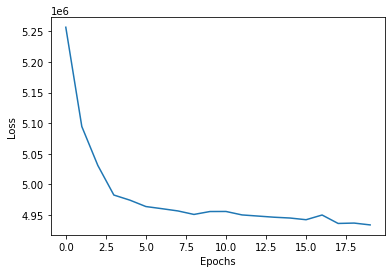

In [17]:
#learning curve

plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

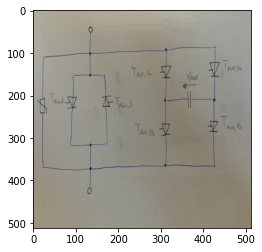

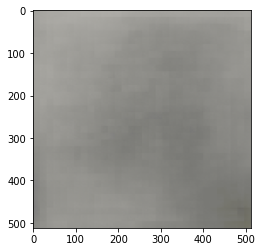

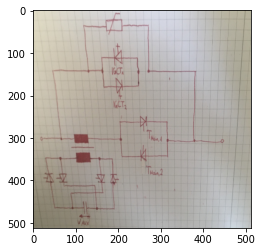

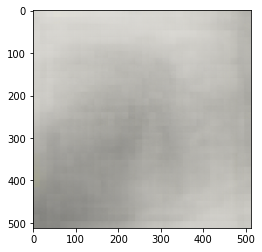

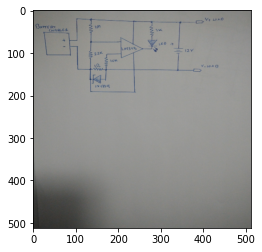

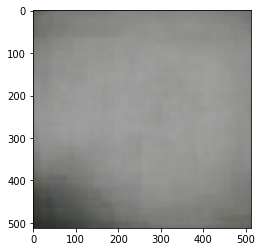

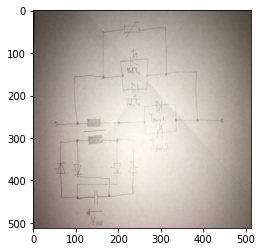

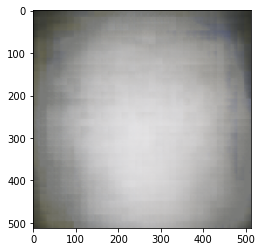

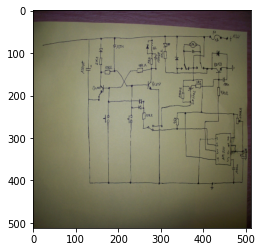

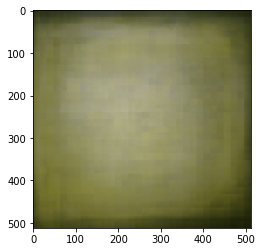

In [21]:
#sample outputs

for i in range(15,len(training_outputs)):
  plt.imshow(training_outputs[i][0].permute(1, 2, 0))
  plt.show()
  plt.imshow(training_outputs[i][1].permute(1, 2, 0).detach().numpy())
  plt.show()